In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cnmfsns as cn
cn.start_logging()

## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [3]:
import pandas as pd

data = pd.read_table("diamandis_data/diamandis_nobulk.txt", index_col=0)  # normalized expression data
metadata = pd.read_table("diamandis_data/diamandis_nobulk.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
diamandis = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col="patient_id")

They can be written to and read from AnnData files (h5ad format).

In [4]:
diamandis.write_h5ad("diamandis.h5ad")  # write to .h5ad file
diamandis = cn.Dataset.from_h5ad("diamandis.h5ad", patient_id_col="patient_id")  # read a .h5ad file

2023-04-17 15:21:59,195 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/tutorial/diamandis.h5ad
2023-04-17 15:21:59,237 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [5]:
diamandis.adata

AnnData object with n_obs × n_vars = 77 × 3560
    obs: 'patient_id', 'simple_category', 'detailed_category', 'age', 'sex', 'location of resection', 'ATRX', 'p53', 'MGMT'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg'

cNMF-SNS can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [6]:
import scanpy

pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset.from_anndata(pbmc_adata)

## Modelling mean and dispersion of genes

In [7]:
diamandis.compute_gene_stats()
diamandis.adata.var.head()  # results are stored in dataset object

,mean,rank_mean,variance,sd,missingness,log_mean,log_variance,mean_counts,odscore_excluded,resid_log_variance,odscore,gam_fittedvalues,vscore
A1BG,1.839333e+07,2152.0,1.787097e+14,1.336824e+07,0.0,7.264660,14.252150,1.839333e+07,False,0.090640,1.109992,14.161510,1.621348
A2M,2.338366e+08,3351.0,2.278611e+16,1.509507e+08,0.0,8.368914,16.357672,2.338366e+08,False,0.040062,1.047204,16.317609,4.806647
AAAS,2.478940e+06,203.0,9.438756e+11,9.715326e+05,0.0,6.394266,11.974916,2.478940e+06,False,-0.186994,0.806312,12.161910,0.077113
AAK1,1.713328e+07,2096.0,2.520759e+14,1.587690e+07,0.0,7.233840,14.401531,1.713328e+07,False,0.294975,1.404389,14.106556,2.489859
AARS1,1.069756e+08,3146.0,9.684864e+14,3.112051e+07,0.0,8.029285,14.986094,1.069756e+08,False,-0.652043,0.472040,15.638138,0.763087


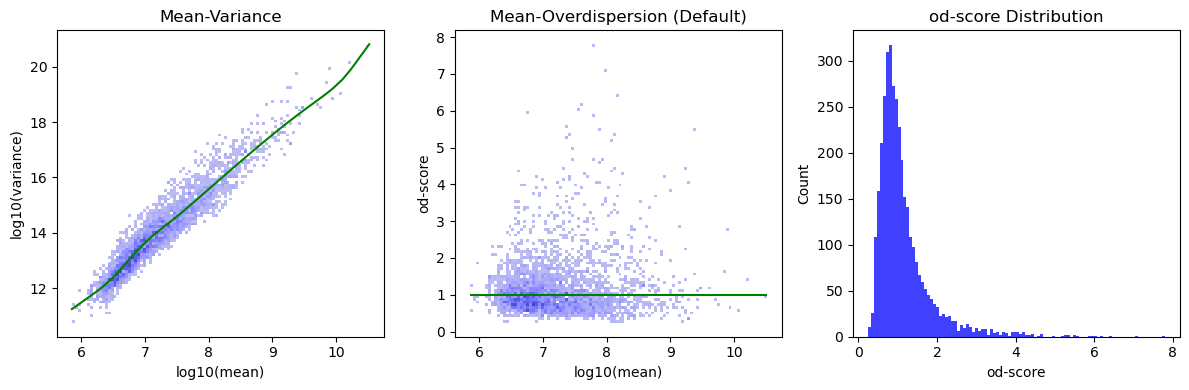

In [8]:
figs = cn.plot_feature_dispersion(diamandis)

## Selecting overdispersed genes

2023-04-17 15:22:02,760 [INFO] 1612 genes selected for factorization


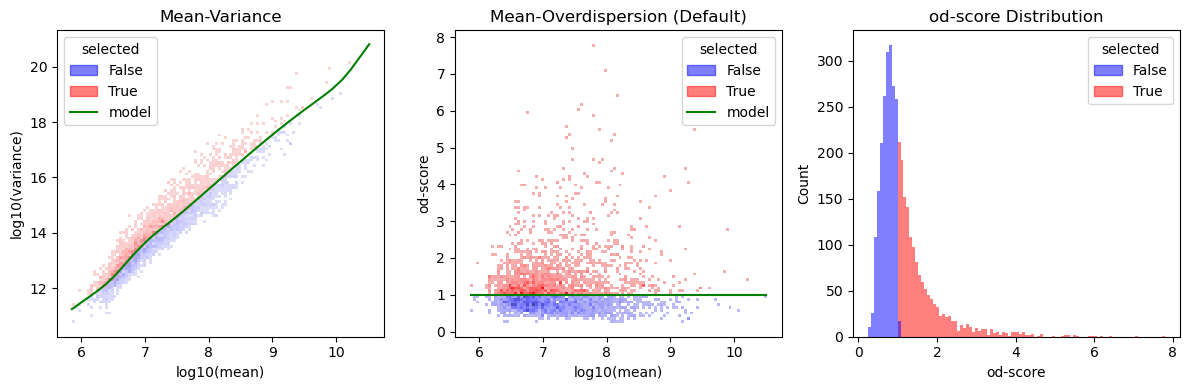

In [9]:
diamandis.select_overdispersed_genes()
figs = cn.plot_feature_dispersion(diamandis, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 50% of genes as being overdispersed:

In [10]:
diamandis.adata.var["selected"].value_counts()

False    1948
True     1612
Name: selected, dtype: int64

## Factorization

In [11]:
cnmf_results_dir = "cnmf_results"
run_name = "diamandis"
# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
kvals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
kvals = [2, 3 ,4, 5, 6, 7, 8]
n_iter = 10

cnmf_run = diamandis.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
diamandis.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
diamandis.write_h5ad("diamandis.h5ad")  # overwrite original file

2023-04-17 15:22:11,329 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-04-17 15:22:11,331 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-04-17 15:22:11,331 [INFO] Creating consensus GEPs and usages for k=2
2023-04-17 15:22:13,412 [INFO] Creating consensus GEPs and usages for k=3
2023-04-17 15:22:16,302 [INFO] Creating consensus GEPs and usages for k=4
2023-04-17 15:22:19,552 [INFO] Creating consensus GEPs and usages for k=5
2023-04-17 15:22:22,311 [INFO] Creating consensus GEPs and usages for k=6
2023-04-17 15:22:25,860 [INFO] Creating consensus GEPs and usages for k=7
2023-04-17 15:22:29,004 [INFO] Creating consensus GEPs and usages for k=8
2023-04-17 15:22:42,170 [INFO] Importing GEPs: gene_spectra_score
2023-04-17 15:22:42,930 [INFO] Importing GEPs: gene_spectra_tpm
2023-04-17 15:22:43,675 [INFO] Importing GEPs: spectra
2023-04-17 15:22:44,012 [INFO] Importing Usages
2023-04-17 15:22:44,037 [INFO] Writing to /home/tbverhey/github/c

## Stability-Error Plot

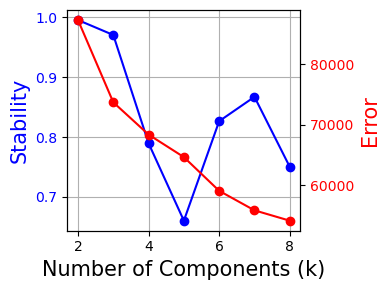

In [12]:
fig = cn.plot_stability_error(diamandis, figsize=[4,3])

fig.savefig("stability-error.pdf")  # Save figures in PDF or PNG format

## Plot GEP usage

In [13]:
diamandis.get_usages()

2                       3                           \
                   1           2           1           2            3   
sample_1   286381.28  67938.8100  276508.160  53482.8800   33261.5350   
sample_10  275490.06  42983.3400  226448.660  32039.3610   63644.2460   
sample_11  304178.94  46940.6760  314947.000  33712.4450   15331.6030   
sample_12  325474.80  25136.4020  350926.120  11225.0020    4852.5537   
sample_13  322751.97  10100.9340  275686.800   3627.7158   59733.5160   
...              ...         ...         ...         ...          ...   
sample_75  381522.03   4371.6580   24525.451   2199.7893  325786.2200   
sample_76  340903.88   7748.7880   77335.640   4292.1865  244665.0000   
sample_77  376044.84   5413.0156   41907.176   3780.4001  305145.0000   
sample_8   296221.78  25721.1450  304933.560  13283.4480   16597.2200   
sample_9   353430.47  23937.2910  359837.780  12863.9890   19261.5880   

                    4                                                5  ...  \
                    1           2            3           4           1  ...   
sample_1   241271.220  35528.7770   31763.7640  55046.7850  199884.920  ...   
sample_10  187847.970  18228.0620   64648.9650  55622.0160  100846.266  ...   
sample_11  296993.250  26519.8980   14571.8890  13477.4960   25600.057  ...   
sample_12  335486.000   8254.6080    3892.7036   4901.7876  240259.470  ...   
sample_13  254060.980   1288.7561   61518.5980  14281.3420   98837.730  ...   
...               ...         ...          ...         ...         ...  ...   
sample_75   13106.181   1608.7062  336973.7000   2401.5867   15062.034  ...   
sample_76   59245.613   2369.2947  254503.3300  10964.6530   28940.553  ...   
sample_77   28807.318   2721.8828  315731.3000   4739.7140   11410.347  ...   
sample_8   237491.980    916.9597   12497.8630  96243.3100  196154.330  ...   
sample_9   343489.000   9771.5110   18624.0270   5223.8438   40490.150  ...   

                     7                         8                           \
                     6           7             1           2            3   
sample_1    49102.1640   6230.4756  32897.297000   50969.477   10368.8730   
sample_10   19657.2910   1283.5410  11526.596000   49081.637   19063.0760   
sample_11   30143.7810   5737.9000  26741.516000  218484.020    9006.9440   
sample_12  258947.0000   3282.7786   3288.130600   58355.540     808.3991   
sample_13   28355.6560   1806.9595    708.693100  139563.970   45384.8240   
...                ...         ...           ...         ...          ...   
sample_75    5018.4473   1546.5199   1528.623300   17802.674  298462.7200   
sample_76    6717.8945    799.2432   1219.850700   36192.020  219361.7300   
sample_77    6067.4805   1074.3352      6.422374    7284.666  238998.2000   
sample_8    24407.9320  13244.5790   1470.202600   63388.420     622.7538   
sample_9    76958.6700   3205.4553  10079.398000  243862.580   14434.0450   

                                                                            
                     4           5            6              7           8  
sample_1   213095.4200  36836.2150   44164.8200   10751.937500  4061.24540  
sample_10  149612.9800   8263.0760   14784.3200   97245.770000  1116.75330  
sample_11   19404.6560  15776.7700   21436.9940   25274.447000  5003.95850  
sample_12   14659.4490  15336.0690  247570.2200      95.262375  2403.98900  
sample_13   84893.7000  40161.2930   22813.1200    6292.429700  1364.79100  
...                ...         ...          ...            ...         ...  
sample_75    8506.3860  22275.7730    4604.9824    1912.483200  1417.75570  
sample_76   54287.2200   4723.6353    5798.0024   17253.164000   714.60150  
sample_77     507.3732   2168.5134    1203.9255  101906.890000   167.86041  
sample_8   247330.4000  44554.9300   18474.6170     469.018340  9496.00400  
sample_9    26684.7900   8348.0290   63413.1640     204.457340  2167.03740  

[77 rows x 35 columns]

2023-04-17 15:22:45,763 [INFO] Choosing distinct colors for metadata layer patient_id
2023-04-17 15:22:46,044 [INFO] Choosing distinct colors for metadata layer simple_category
2023-04-17 15:22:46,081 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-04-17 15:22:46,120 [INFO] Choosing distinct colors for metadata layer sex
2023-04-17 15:22:46,134 [INFO] Choosing distinct colors for metadata layer location of resection
2023-04-17 15:22:46,315 [INFO] Choosing distinct colors for metadata layer ATRX
2023-04-17 15:22:46,328 [INFO] Choosing distinct colors for metadata layer p53
2023-04-17 15:22:46,347 [INFO] Choosing distinct colors for metadata layer MGMT


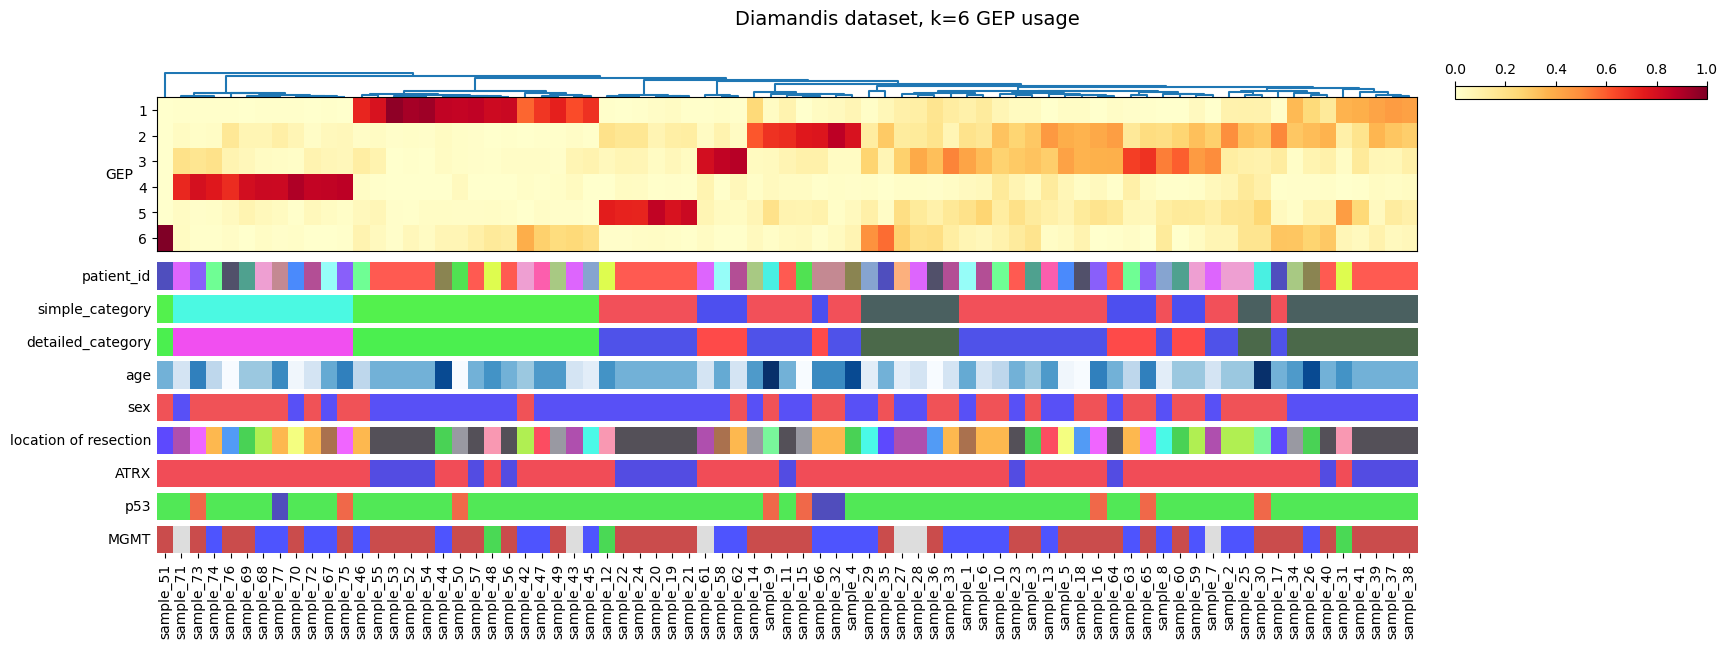

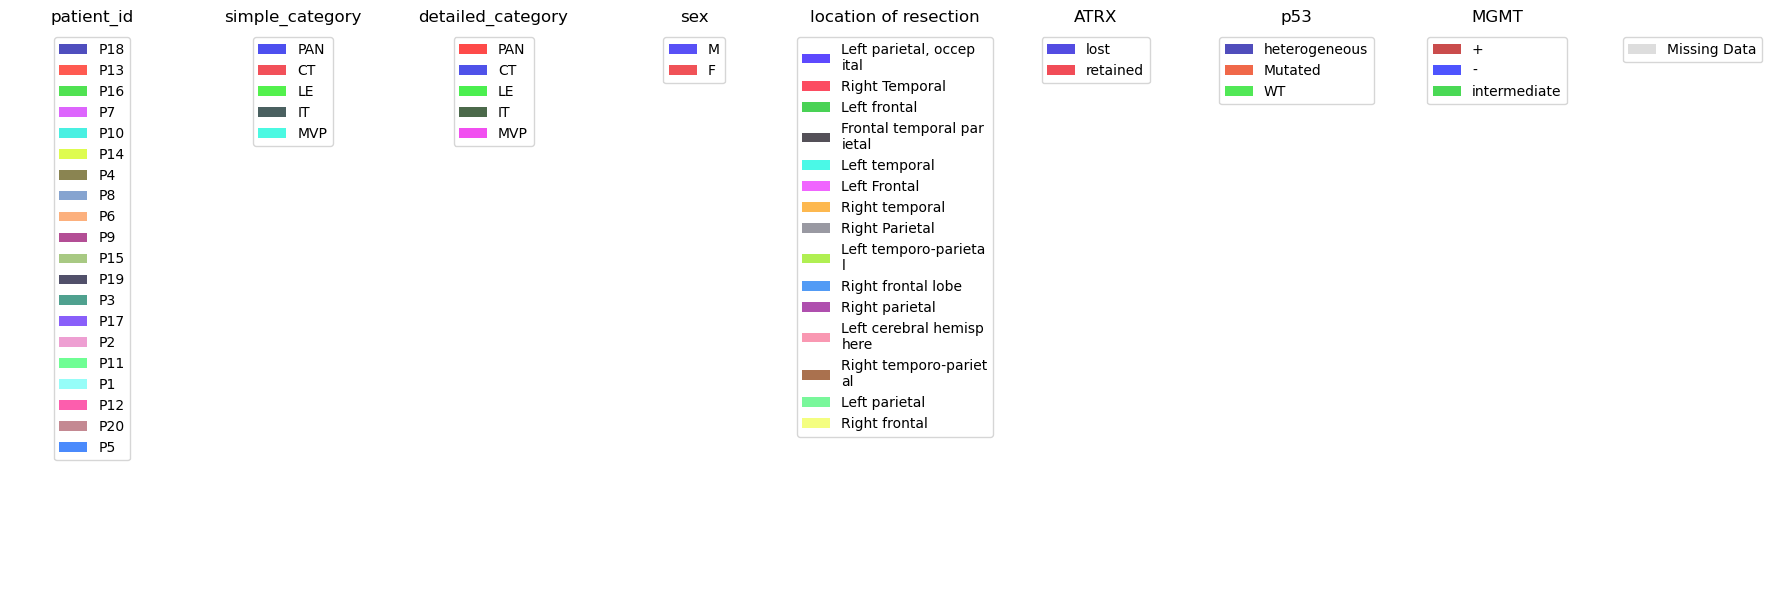

In [14]:
colors = cn.Colors.from_dataset(diamandis, pastel_factor=0.4)  # create distinct colors for metadata tracks


fig = cn.plot_usage_heatmap(diamandis, k=6, colors=colors,
                                     title="Diamandis dataset, k=6 GEP usage")
fig.savefig("k6_usages_heatmap.pdf")

fig_legend = colors.plot_metadata_colors_legend()
fig.savefig("diamandis_metadata_colors_legend.pdf")

## Factorize a second dataset for integration

In [15]:
data = pd.read_csv("cptac_data/cptac_gbm.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_gbm.metadata.txt", index_col=0)  # sample metadata

# create dataset from CPTAC example data
cptac = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col = "patient_id")
cptac.compute_gene_stats()
cptac.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "cptac"
cnmf_run = cptac.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
cptac.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
cptac.write_h5ad("cptac.h5ad")  # write to h5ad file

2023-04-17 15:22:53,327 [INFO] 4554 genes selected for factorization
2023-04-17 15:25:09,779 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-04-17 15:25:09,784 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-04-17 15:25:09,787 [INFO] Creating consensus GEPs and usages for k=2
2023-04-17 15:25:13,138 [INFO] Creating consensus GEPs and usages for k=3
2023-04-17 15:25:16,385 [INFO] Creating consensus GEPs and usages for k=4
2023-04-17 15:25:20,141 [INFO] Creating consensus GEPs and usages for k=5
2023-04-17 15:25:23,840 [INFO] Creating consensus GEPs and usages for k=6
2023-04-17 15:25:27,436 [INFO] Creating consensus GEPs and usages for k=7
2023-04-17 15:25:31,645 [INFO] Creating consensus GEPs and usages for k=8
2023-04-17 15:25:49,301 [INFO] Importing GEPs: gene_spectra_score
2023-04-17 15:25:51,944 [INFO] Importing GEPs: gene_spectra_tpm
2023-04-17 15:25:55,001 [INFO] Importing GEPs: spectra
2023-04-17 15:25:56,117 [INFO] Importing Usa

## Integrate multiple datasets together

In [16]:
datasets = {"CPTAC": cptac,
            "Diamandis": diamandis}
integration = cn.Integration(datasets=datasets)  # create an integration object
colors = cn.Colors.from_integration(integration)  # create color scheme for metadata and datasets
colors.to_toml("colors.toml")  # save to file for reference (TOML file can be re-imported)

2023-04-17 15:25:56,781 [INFO] nancorrmp found. Calculating Pearson correlation matrix using 16 CPUs.
2023-04-17 15:25:57,255 [INFO] Choosing distinct dataset colors
2023-04-17 15:25:57,290 [INFO] Choosing distinct colors for metadata layer patient_id
2023-04-17 15:26:05,891 [INFO] Choosing distinct colors for metadata layer simple_category
2023-04-17 15:26:05,911 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-04-17 15:26:05,930 [INFO] Choosing distinct colors for metadata layer multiomic
2023-04-17 15:26:05,957 [INFO] Choosing distinct colors for metadata layer r_wang_cancer_cell_2017
2023-04-17 15:26:05,984 [INFO] Choosing distinct colors for metadata layer d_methyl
2023-04-17 15:26:06,046 [INFO] Choosing distinct colors for metadata layer d_methyl_mnp
2023-04-17 15:26:06,141 [INFO] Choosing distinct colors for metadata layer is_gcimp
2023-04-17 15:26:06,156 [INFO] Choosing distinct colors for metadata layer immune
2023-04-17 15:26:06,186 [INFO] Choosing di

In [17]:
integration.k_subset

(2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60)

Identify gene overlap between datasets

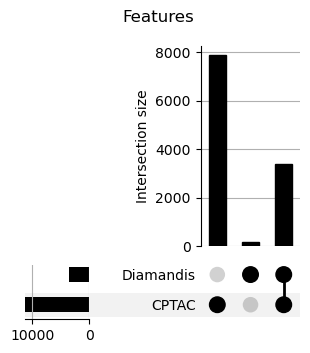

In [18]:
cn.plot_features_upset(integration)

A subset of these are identified as overdispersed in each dataset, and there is a significant overlap between datasets, indicating similar variation is seen in the two separate datasets.

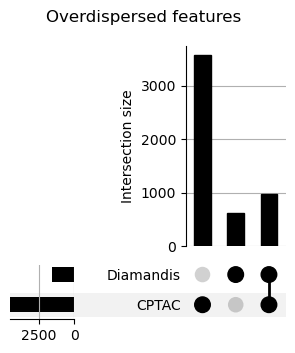

In [19]:
cn.plot_overdispersed_features_upset(integration)

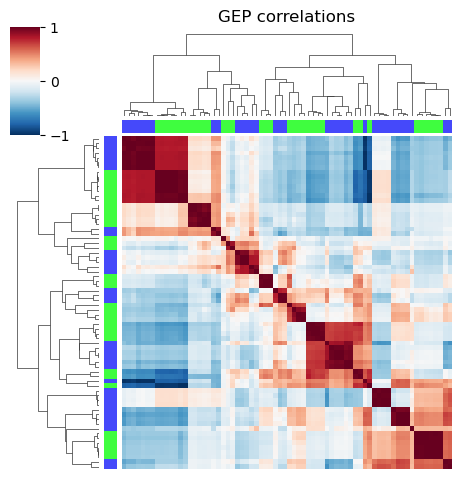

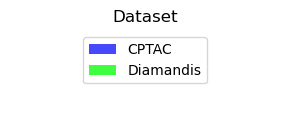

In [20]:
# plot the correlation matrix of all GEPs to each other
fig = cn.plot_gep_correlation_matrix(integration, colors=colors, figsize=[6, 6], hide_gep_labels=True)
fig.savefig("correlation_matrix.pdf")

# plot the legend separately as it applies to multiple figures
figlegend = colors.plot_dataset_colors_legend()
figlegend.savefig("datasets_legend.pdf")

To see if the `max_median_corr` threshold removed any ranks from either of the datasets, the following plot can be generated. The x-axis is the max-k, a threshold that excludes ranks above. The y-axis is the median of the correlation coefficients for all non-self edges in the correlation network. As this this threshold is slowly increased, the number of ranks, and thus nodes, and thus edges increases. The correlation between all edges slowly increases. In some datasets, this median of correlations will exceed 0 at high ranks. These high ranks will be excluded by this filter.

You can easily see for each rank whether there is a cNMF result, the stability/error of the result, as well as whether the ranks will be excluded on the basis of a max-k filter (derived from the max_median_corr parameter). You can also see which ranks will be selected (selected_k) based on automatic node subsetting for the final SNS maps.

In [21]:
integration.k_table

CPTAC                                                                  \
  cNMF result max_k_filter_pass max_k_median_corr prediction_error selected_k   
2        True              True         -0.991546     297206.84375       True   
3        True              True         -0.470186     271496.43750       True   
4        True              True         -0.358913     255003.03125       True   
5        True              True         -0.183299     241625.46875       True   
6        True              True         -0.171640     231677.65625       True   
7        True              True         -0.140515     227566.62500       True   
8        True              True         -0.120692     221269.78125       True   

              Diamandis                                                       \
  stability cNMF result max_k_filter_pass max_k_median_corr prediction_error   
2  0.992847        True              True         -0.999225     87354.546875   
3  0.862969        True              True         -0.422642     73716.046875   
4  0.711973        True              True         -0.218081     68367.125000   
5  0.685838        True              True         -0.198621     64632.328125   
6  0.714274        True              True         -0.152063     59042.601562   
7  0.483988        True              True         -0.126560     55810.679688   
8  0.467446        True              True         -0.106656     54094.496094   

                        
  selected_k stability  
2       True  0.995756  
3       True  0.970752  
4       True  0.789592  
5       True  0.660088  
6       True  0.826561  
7       True  0.867268  
8       True  0.750164

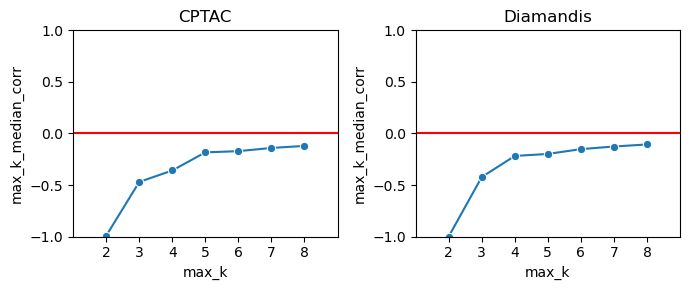

In [22]:
fig = cn.plot_rank_reduction(integration)

You can see that no k-values exceeded the threshold, so no max_k filter was applied. Now, let's plot the distribution of correlations for GEPs within and between datasets. This will show the min_corr thresholds. There is one threshold per dataset pair, and one threshold for within each dataset.

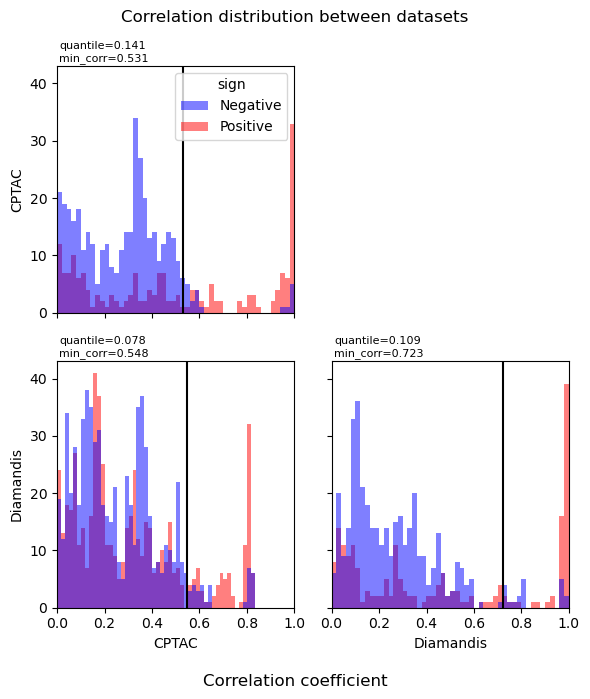

In [23]:
# fig = cn.plot_pairwise_corr(integration)
fig2 = cn.plot_pairwise_corr_overlaid(integration)  # overlaid plots show the mirrored distributions

See the number of nodes from each dataset with and without the node filters (including maxk and selectedk filters) and the edge filter (min_corr thresholds).

In [24]:
integration.get_node_table()

Node filter none         maxk         selectedk        
Edge Filter none mincorr none mincorr      none mincorr
CPTAC         35      35   35      35        35      35
Diamandis     35      35   35      35        35      35

## Create an SNS integration

2023-04-17 15:26:12,558 [INFO] Community search: algorithm = greedy_modularity, resolution = 1
2023-04-17 15:26:12,573 [INFO] Creating community network


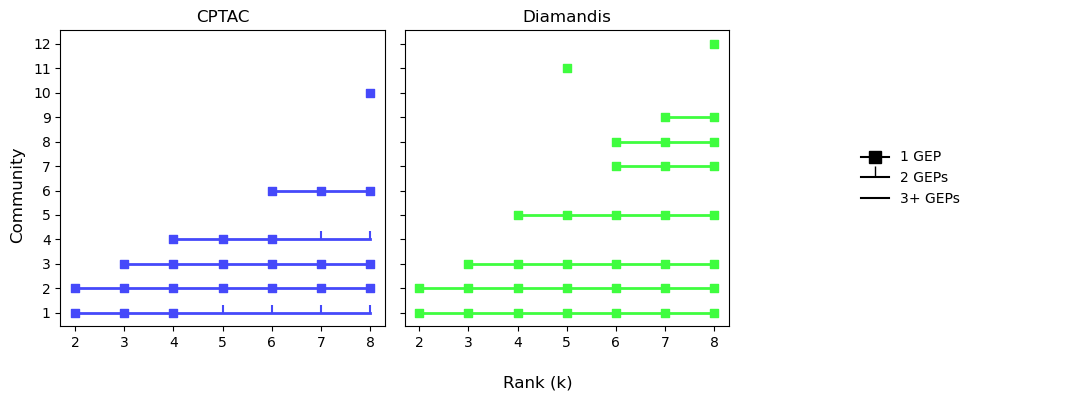

In [25]:
snsmap = cn.SNS(integration)
snsmap.community_search(algorithm="greedy_modularity", resolution=1)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

# Plot an SNS Map

2023-04-17 15:26:13,610 [INFO] Computing community layout using spring method.


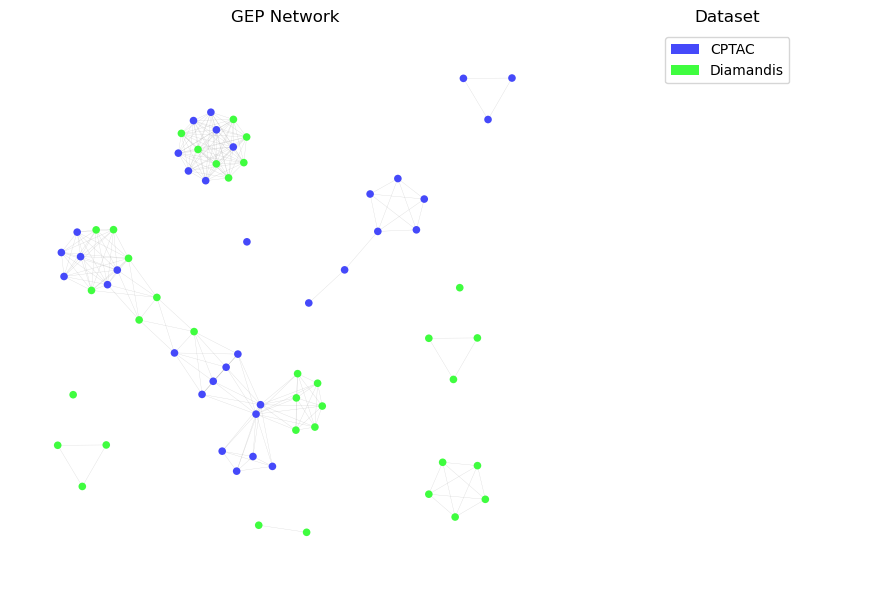

In [26]:
snsmap.compute_layout(algorithm="neato")
fig = cn.plot_gep_network_datasets(snsmap, colors, node_size_kval=False)

How many samples have each GEP/node as their highest usage GEP? 

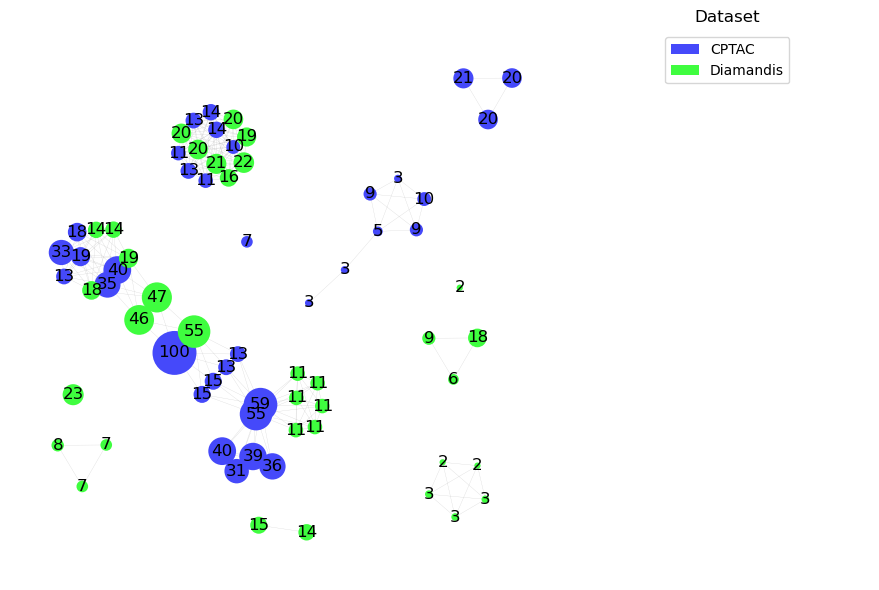

In [27]:
fig = cn.plot_gep_network_nsamples(snsmap,
                                  colors,
                                  node_size=1e3,
                                  font_size=12,
                                  discretize=True)

How many patients is each GEP primarily associated to?

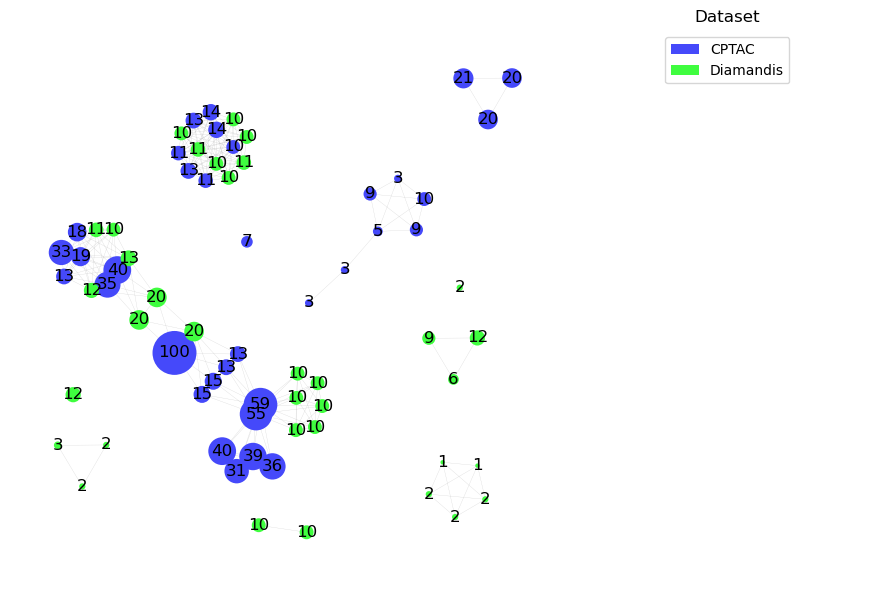

In [28]:
fig = cn.plot_gep_network_npatients(snsmap, colors, node_size=1e3, font_size=12)


Overrepresentation of sample categories for each GEP on the network

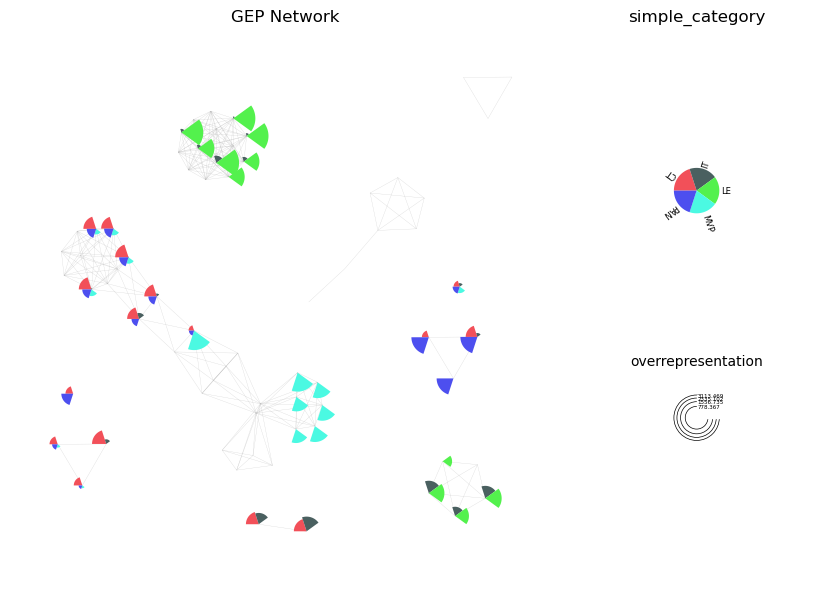

In [29]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="Diamandis", layer="simple_category")
fig.savefig("diamandis_overrepresentation.pdf")

And again, using the CPTAC annotations

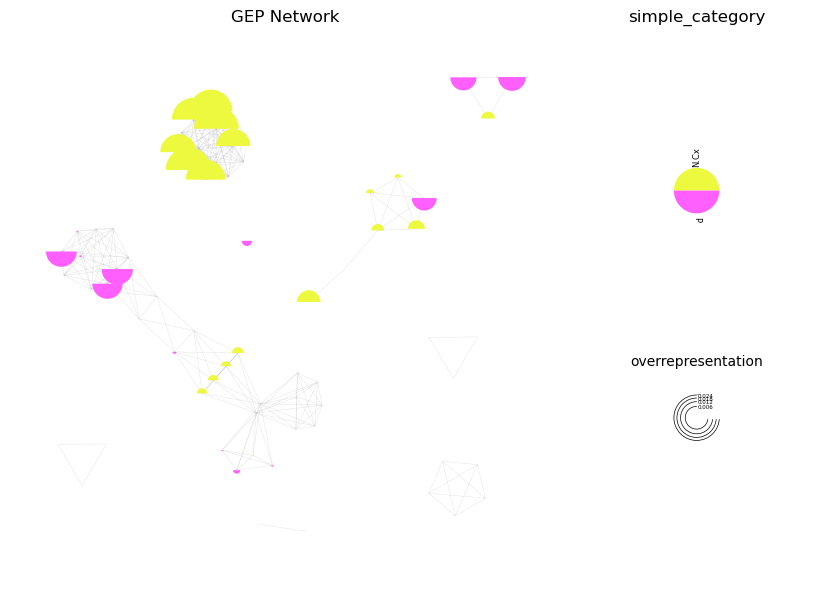

In [30]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="CPTAC", layer="simple_category")
fig.savefig("cptac_overrepresentation.pdf")

You can also look at continuous metadata correlated with GEP usage, like age:

# Identifying GEP Communities

2023-04-17 15:26:17,416 [INFO] Choosing distinct community colors


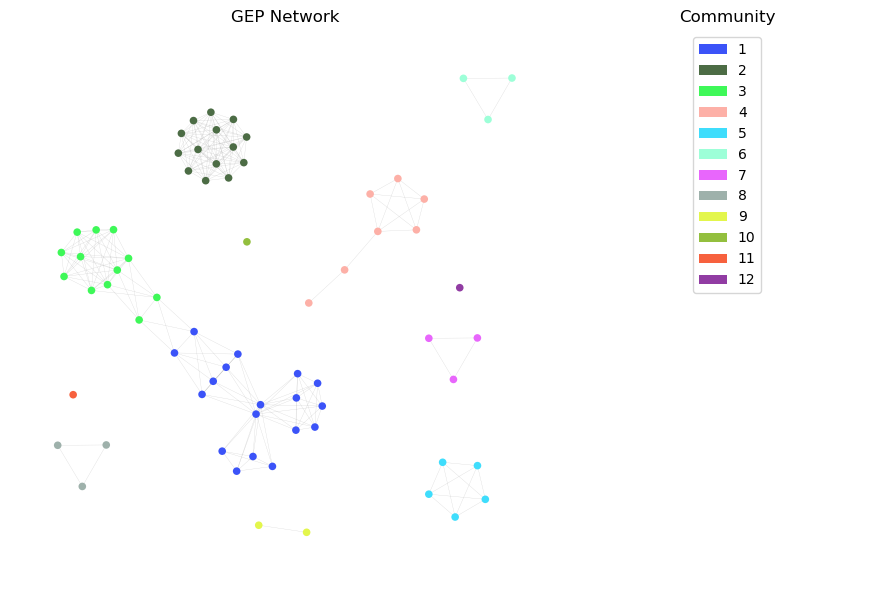

In [31]:
colors.add_missing_community_colors(snsmap)
fig = cn.plot_gep_network_communities(snsmap, colors)

Plot a summary showing the size of each community (node size) and number of edges connecting communities (edge width).

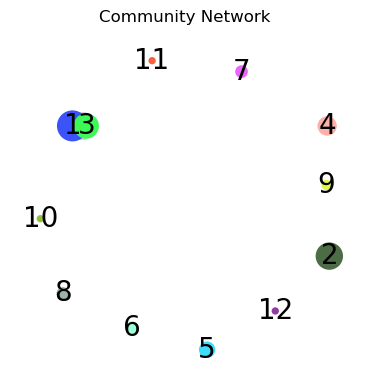

In [32]:
fig = cn.plot_summary_community_network(snsmap, colors)

Plot GEP usage heatmap summarized by Community

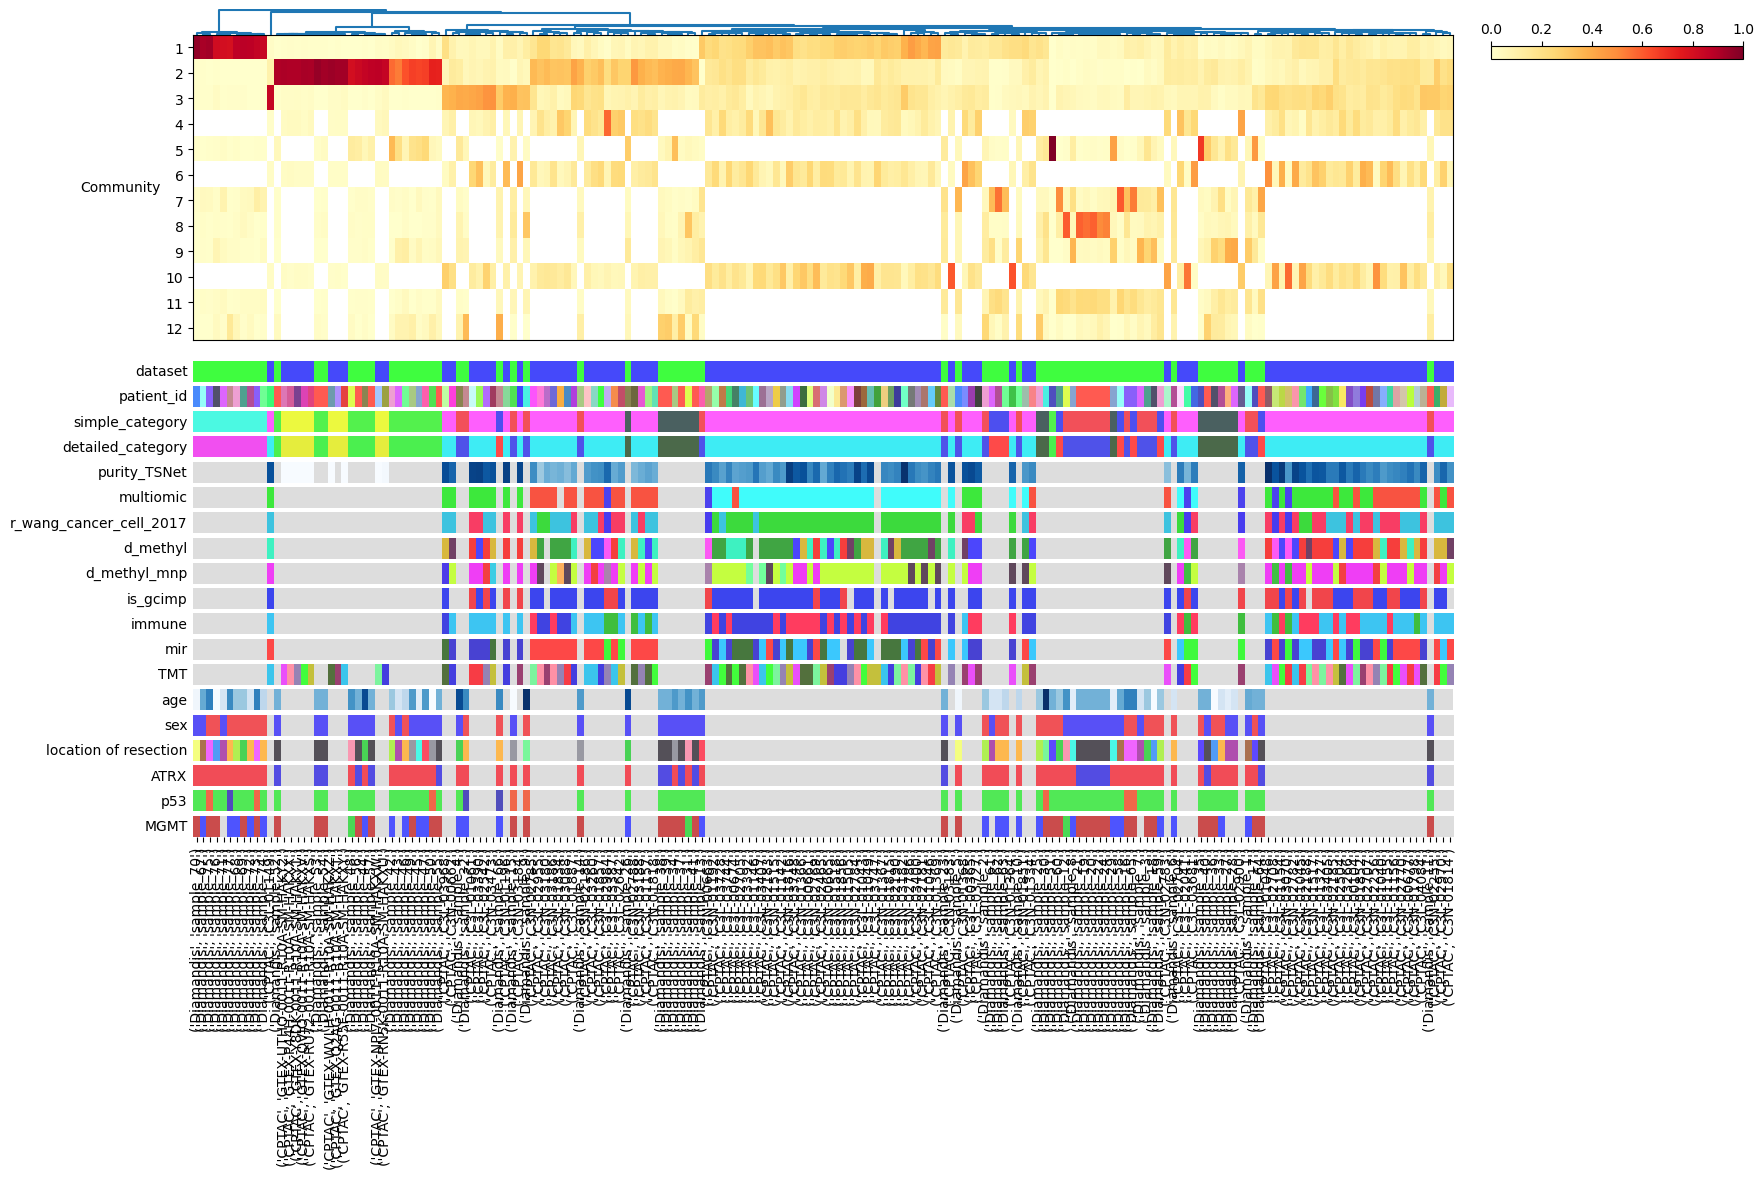

In [52]:
fig = cn.plot_community_usage_heatmap(snsmap, colors, prepend_dataset_colors=True)
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation categorical variables with usage of GEPs, grouped by community

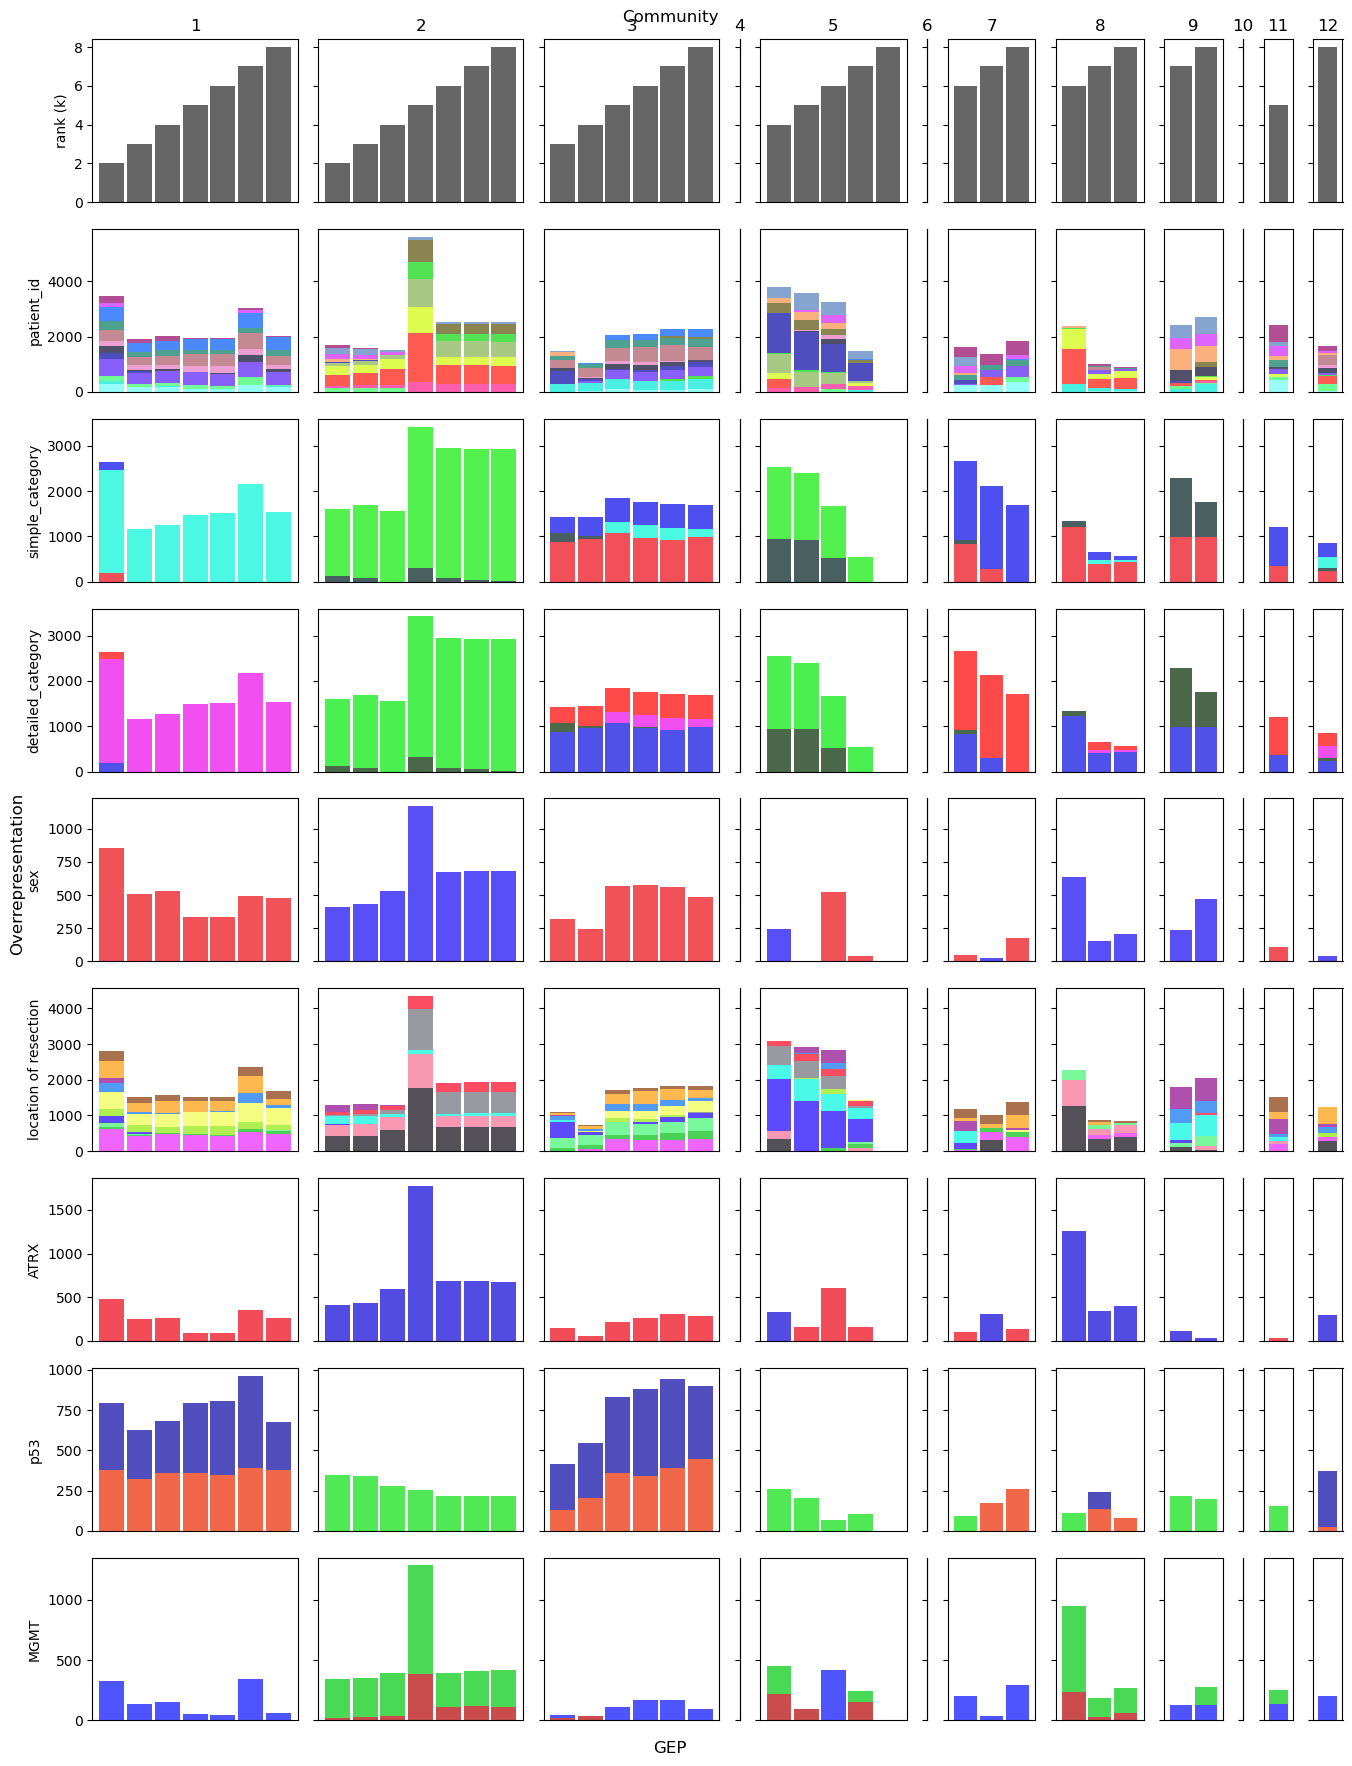

In [34]:
fig = cn.plot_overrepresentation_gep_bar(snsmap, colors, dataset_name="Diamandis")
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation GEPs in each community with continuous variables like `age`

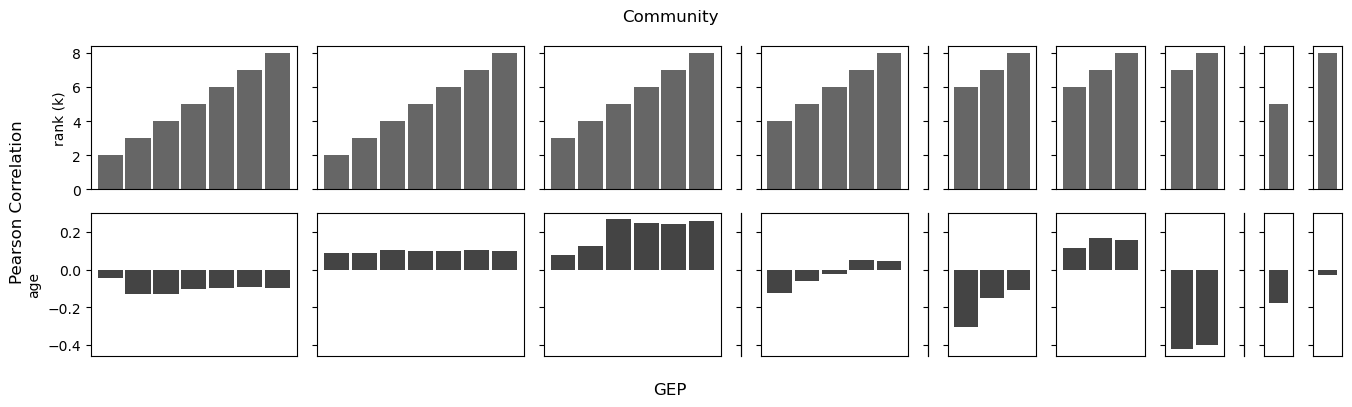

In [35]:
fig = cn.plot_metadata_correlation_gep_bar(snsmap, colors, dataset_name="Diamandis")

# Community-level summary of overrepresentation

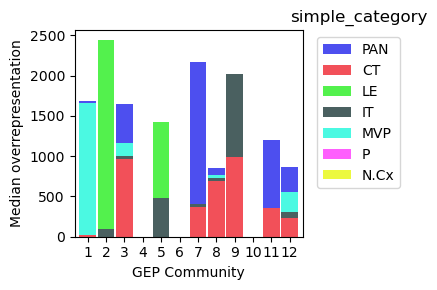

In [36]:
fig = cn.plot_overrepresentation_community_bar(snsmap, colors, layer="simple_category", subset_datasets="Diamandis")

Or, plot it on the network:

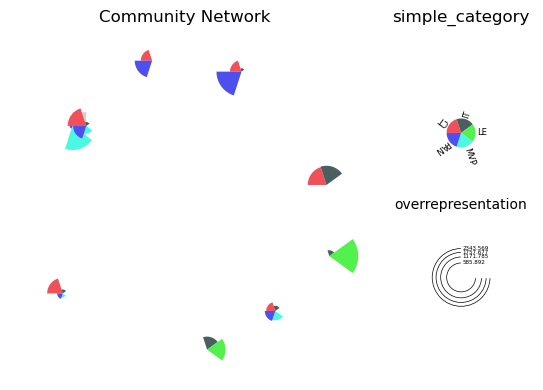

In [37]:
fig = cn.plot_overrepresentation_community_network(snsmap, colors, layer="simple_category", pie_size=0.2, subset_datasets="Diamandis")

# Summarizing correlation with metadata

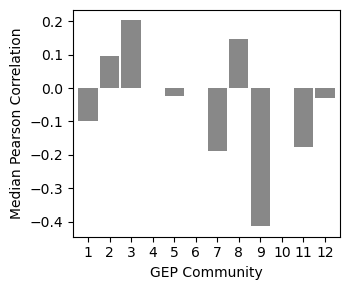

In [38]:
fig = cn.plot_metadata_correlation_community_bar(snsmap, colors, layer="age", subset_datasets="Diamandis")

Or, plot it on the network:

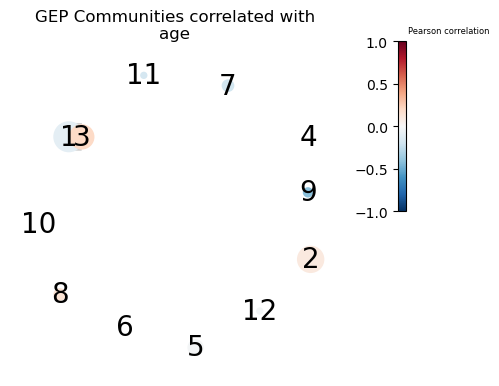

In [39]:
fig = cn.plot_metadata_correlation_community_network(snsmap, colors, layer="age", subset_datasets="Diamandis")

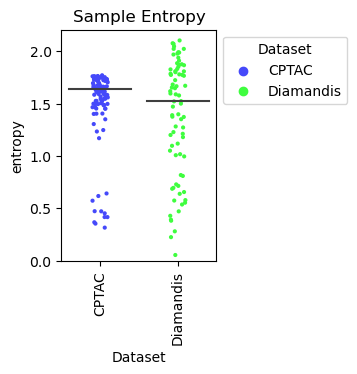

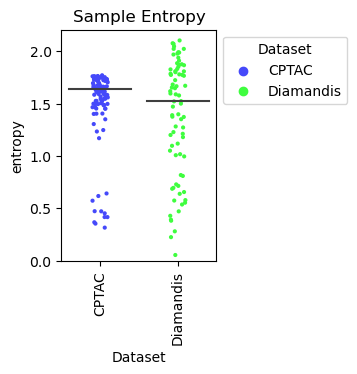

In [40]:
cn.plot_sample_entropy(snsmap, colors)